<a href="https://colab.research.google.com/github/isa-ulisboa/greends-pml/blob/main/fast_ai_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting survival of Titanic passengers

Works with fastai version 2.7.11

In [1]:
#!pip install -q fastai --upgrade



In [2]:
import fastai
print(fastai.__version__)

2.7.12


In [3]:
from fastai import *
from fastai.tabular.all import *
import pandas as pd

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load data

In [5]:
train_df = pd.read_csv('/content/drive/MyDrive/AAA/Lesson_5/titanic_data/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/AAA/Lesson_5/titanic_data/test.csv')
print(train_df.shape,test_df.shape)
train_df.head()

(891, 12) (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Feature engineering
- Extract *Title* from the name colum. 
- Extract *Deck* from the first character of the cabin number.
- Fill in missing *Age* values with the mean age for passengers with the same title.

In [6]:
for df in [train_df, test_df]:
    df['Title'] = df['Name'].str.split(',').str[1].str.split(' ').str[1]
    df['Deck'] = df['Cabin'].str[0]

# find mean age for each Title across train and test data sets
all_df = pd.concat([train_df, test_df], sort=False)
mean_age_by_title = all_df.groupby('Title').mean()['Age']
# update missing ages
for df in [train_df, test_df]:
    for title, age in mean_age_by_title.iteritems():
        df.loc[df['Age'].isnull() & (df['Title'] == title), 'Age'] = age

<ipython-input-6-dcf17dc8baed>:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_age_by_title = all_df.groupby('Title').mean()['Age']
<ipython-input-6-dcf17dc8baed>:10: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for title, age in mean_age_by_title.iteritems():


In [7]:
test_df.Fare.fillna(0,inplace=True)

In [8]:
train_df.shape

(891, 14)


## Fastai setup

In [9]:
dep_var = 'Survived'
cat_names = ['Pclass', 'Sex', 'Embarked', 'Title', 'Deck']
cont_names = ['Age', 'Fare', 'SibSp', 'Parch']
procs = [FillMissing,Categorify, Normalize] #, 

The last part is the list of pre-processors we apply to our data:

1. `Categorify` is going to take every categorical variable and make a map from integer to unique categories, then replace the values by the corresponding index.
2. `FillMissing` will fill the missing values in the continuous variables by the median of existing values (you can choose a specific value if you prefer)
3. `Normalize` will normalize the continuous variables (subtract the mean and divide by the std)


In [106]:
# Define custom accessor
class MyAccessor(pd.api.extensions.ExtensionArray):

    def set_cat_cols(self, cols):
        for col in cols:
            self._data.set_cat_categories([col])
            self._data[col] = self._data[col].cat.codes + 1

    def set_emb_szs(self, cols, szs):
        for col in cols:
            self._data[col].cat.set_categories(range(1, len(self._data[col].cat.categories)+1))
            self._data[col].cat.set_ordered(False)
            self._data[col].cat.set_emb_sz({col: szs[col]})
          
# Register the accessor
pd.DataFrame.mya = MyAccessor

# example usage
df = pd.DataFrame({
    'color': ['red', 'green', 'blue', 'red', 'green'],
    'size': ['small', 'medium', 'large', 'small', 'medium'],
    'price': [10, 20, 30, 15, 25],
})

df['color'] = df['color'].astype('category')
df['size'] = df['size'].astype('category')

# set embedding sizes using the custom accessor
df.mya.set_emb_szs(['color', 'size'], {'color': 2, 'size': 3})


TypeError: ignored

In [104]:
import pandas as pd

class MyAccessor:
    def __init__(self, data):
        self._data = data

    @property
    def cat(self):
        return self._data.select_dtypes(include=['category'])

    def set_emb_szs(self, cat_cols, szs):
        for col in cat_cols:
            self.cat[col].cat.set_categories(self.cat[col].cat.categories[:szs[col]], ordered=True)

pd.DataFrame.mya = MyAccessor

# example usage
df = pd.DataFrame({
    'color': ['red', 'green', 'blue', 'red', 'green'],
    'size': ['small', 'medium', 'large', 'small', 'medium'],
    'price': [10, 20, 30, 15, 25],
})

df['color'] = df['color'].astype('category')
df['size'] = df['size'].astype('category')

# set embedding sizes using the custom accessor
df.mya.set_emb_szs(['color', 'size'], {'color': 2, 'size': 3})


TypeError: ignored

In [103]:
from pandas.api.types import CategoricalDtype
from pandas.api.extensions import register_dataframe_accessor
import pandas as pd
from fastai.tabular.all import *

# Define a custom accessor
@pd.api.extensions.register_dataframe_accessor("mya")
class MyAccessor:
    def __init__(self, data):
        self._data = data

    @property
    def cat(self):
        return self._data.select_dtypes(include=['category'])

    def set_emb_szs(self, cat_cols, szs):
        for col in cat_cols:
            self.cat[col].cat.set_categories(self.cat[col].cat.categories[:szs[col]], ordered=True)

# example usage
df = pd.DataFrame({
    'color': ['red', 'green', 'blue', 'red', 'green'],
    'size': ['small', 'medium', 'large', 'small', 'medium'],
    'price': [10, 20, 30, 15, 25],
})

df['color'] = df['color'].astype('category')
df['size'] = df['size'].astype('category')

# set embedding sizes using the custom accessor
df.mya.set_emb_szs(['color', 'size'], {'color': 2, 'size': 3})

# Create a TabularPandas object
to = TabularPandas(df, procs=[Categorify, FillMissing, Normalize], cat_names=['color', 'size'], cont_names=['price'], y_names='label')



<ipython-input-103-5778c648bd39>:7: UserWarning: registration of accessor <class '__main__.MyAccessor'> under name 'mya' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  class MyAccessor:


KeyError: ignored

In [85]:
cat_emb={'Title': 5}

In [86]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names=cat_names ,
                   cont_names = cont_names,
                   y_names=dep_var,
                   splits=splits,
                   y_block = CategoryBlock, # when y's are 0/1 but we don't want to do regression
                   **{'cat_emb': cat_emb}) 


TypeError: ignored

In [70]:
# Set the embedding size for each categorical variable
to.train['Title'].unique()
to.emb_szs

AttributeError: ignored

In [ ]:

dls = to.dataloaders(bs=64) # dataloaders

In [11]:
to.train.items['Title']

834    12
761    12
536     7
729     9
842     9
       ..
614    12
533    13
770    12
23     12
329     9
Name: Title, Length: 713, dtype: int8

Build learner, which is a multi-layer neural network, and includes layers for categorical embedding.

In [12]:
learn = tabular_learner(dls, metrics=accuracy)

`learn.model` does a preview of the model. `LinBnDrop` is a module grouping three components: `BatchNorm1d`, `Dropout` and Linear layers

In [13]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(4, 3)
    (1): Embedding(3, 3)
    (2): Embedding(4, 3)
    (3): Embedding(18, 8)
    (4): Embedding(9, 5)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=26, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=200, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=2, bias=True)
    )
  )
)

### Let's look at the categorical embedding part of the network:

For fundamentals, see paper "Entity Embeddings of Categorical Variables" https://arxiv.org/abs/1604.06737. 

In [14]:
print(cat_names)
print('number categories for Title:',len(train_df['Title'].unique()),train_df['Title'].unique()) # same as list(train_df['Title'].astype('category').cat.categories.values)
print('number categories for Deck:',len(train_df['Deck'].unique()),train_df['Deck'].unique())
print(learn.model.embeds) # one row per categorial variable Notice that: cat_names = ['Pclass', 'Sex', 'Embarked', 'Title', 'Deck']

['Pclass', 'Sex', 'Embarked', 'Title', 'Deck']
number categories for Title: 17 ['Mr.' 'Mrs.' 'Miss.' 'Master.' 'Don.' 'Rev.' 'Dr.' 'Mme.' 'Ms.' 'Major.'
 'Lady.' 'Sir.' 'Mlle.' 'Col.' 'Capt.' 'the' 'Jonkheer.']
number categories for Deck: 9 [nan 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']
ModuleList(
  (0): Embedding(4, 3)
  (1): Embedding(3, 3)
  (2): Embedding(4, 3)
  (3): Embedding(18, 8)
  (4): Embedding(9, 5)
)


Method `lr_find` helps to find a good learning rate. 

SuggestedLRs(valley=0.002511886414140463)

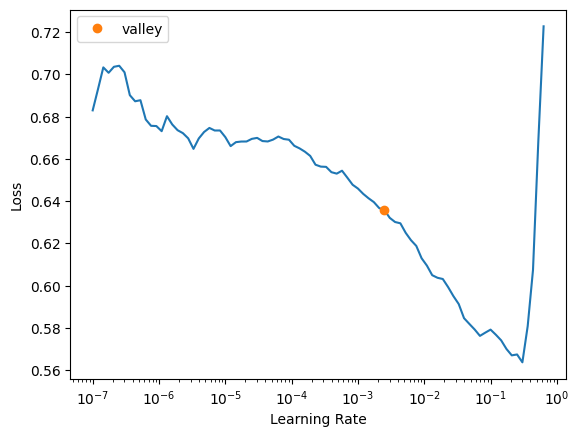

In [15]:
learn.lr_find()

In [16]:
learn.fit_one_cycle(12, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.631498,0.667177,0.685393,00:00
1,0.606221,0.650273,0.662921,00:00
2,0.575805,0.540369,0.775281,00:00
3,0.538111,0.457363,0.814607,00:00
4,0.505063,0.467573,0.803371,00:00
5,0.483108,0.491221,0.780899,00:00
6,0.457499,0.430176,0.825843,00:00
7,0.434967,0.442481,0.814607,00:00
8,0.418706,0.449551,0.775281,00:00
9,0.406566,0.441846,0.814607,00:00


### Replace each categorical value with its embedding vector

In [17]:
# from https://towardsdatascience.com/entity-embeddings-for-ml-2387eb68e49
def embed_features(learner, xs):
  """
  learner: fastai Learner used to train the neural net
  xs: DataFrame containing input variables. Categorical values are defined by their rank. 
 ::return:: copy of `xs` with embeddings replacing each categorical variable
  """
  xs = xs.copy()
  for i,col in enumerate(learn.dls.cat_names):
    
    # get matrix containing each row's embedding vector
    emb = learn.model.embeds[i]
    emb_data = emb(tensor(xs[col], dtype=torch.int64))
    emb_names = [f'{col}_{j}' for j in range(emb_data.shape[1])]
    
    # join the embedded category and drop the old feature column
    feat_df = pd.DataFrame(data=emb_data, index=xs.index,               
                           columns=emb_names)
    xs = xs.drop(col, axis=1)
    xs = xs.join(feat_df)
  return xs


In [46]:
# names of columns with 'Title'
colsTitle=[x for x in emb_train_xs.columns if 'Title' in x]

In [56]:
# show embeddings and raw (original) variables
emb_train_xs = embed_features(learn, to.train.xs)
emb_valid_xs = embed_features(learn, to.valid.xs)
# To merge two Pandas DataFrames by index, you can use the merge() method and specify left_index=True and right_index=True.
train_merge=pd.merge(emb_train_xs, train_df, left_index=True, right_index=True)
train_merge[cat_names+colsTitle].head()


,Pclass,Sex,Embarked,Title,Deck,Title_0,Title_1,Title_2,Title_3,Title_4,Title_5,Title_6,Title_7
834,3,male,S,Mr.,NaN,0.064313,-0.008791,-0.064376,-0.058770,-0.059425,-0.028048,-0.071565,-0.062305
761,3,male,S,Mr.,NaN,0.064313,-0.008791,-0.064376,-0.058770,-0.059425,-0.028048,-0.071565,-0.062305
536,1,male,S,Major.,B,0.004329,-0.018394,0.012813,0.002383,0.023162,0.002816,0.001068,-0.018056
729,3,female,S,Miss.,NaN,-0.024271,-0.008389,0.023202,0.021046,0.028977,-0.021679,0.040623,0.017113
842,1,female,C,Miss.,NaN,-0.024271,-0.008389,0.023202,0.021046,0.028977,-0.021679,0.040623,0.017113


In [52]:
# show embeddings and raw (original) variables
emb_train_xs = embed_features(learn, to.train.xs)
emb_valid_xs = embed_features(learn, to.valid.xs)
#print(emb_train_xs.iloc[10:13,~emb_train_xs.columns.isin(cont_names)]) # embeddings
print(emb_train_xs.sort_index()[colsTitle].iloc[10:14]) # embeddings
print(train_df.sort_index()[cat_names].iloc[10:14]) # original variables

     Title_0   Title_1   Title_2   Title_3   Title_4   Title_5   Title_6  \
13  0.064313 -0.008791 -0.064376 -0.058770 -0.059425 -0.028048 -0.071565   
14 -0.024271 -0.008389  0.023202  0.021046  0.028977 -0.021679  0.040623   
16 -0.030491  0.040602  0.049816  0.026044  0.064817  0.051379  0.063088   
17  0.064313 -0.008791 -0.064376 -0.058770 -0.059425 -0.028048 -0.071565   

     Title_7  
13 -0.062305  
14  0.017113  
16  0.038533  
17 -0.062305  
    Pclass     Sex Embarked  Title Deck
10       3  female        S  Miss.    G
11       1  female        S  Miss.    C
12       3    male        S    Mr.  NaN
13       3    male        S    Mr.  NaN


In [40]:
# DataFrame with titles and codes
title_name=train_df['Title'].sort_index()
title_code=to.train.items['Title'].sort_index()
title_df=pd.DataFrame({'Code': title_code, 'Title': title_name})
title_df=title_df.dropna().drop_duplicates()
title_df=title_df.sort_values('Code')

(17, 8)
(17,)


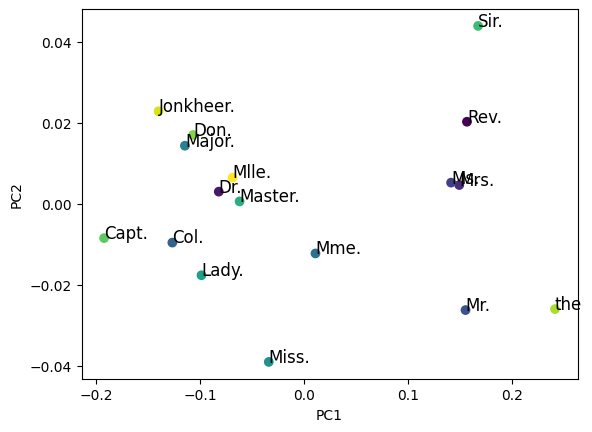

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
import seaborn as sns
titleCols=[x for x in emb_train_xs.columns if 'Title' in x]
X=array(emb_train_xs[titleCols])
y=array(to.train.items['Title'])
Z=np.concatenate((X,np.reshape(y, (X.shape[0], 1))),axis=1)
Z=np.unique(Z, axis=0)
X=Z[:, :-1]
y=Z[:,-1]
print(X.shape)
print(y.shape)
# colors = sns.color_palette(None, len(target_names))
# lda = LinearDiscriminantAnalysis(n_components=2)
# X_r = lda.fit(X, y).transform(X)
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)
#for i, label in enumerate(labels):
#    plt.annotate(label, (X_pca[i:, 0], X_pca[i:, 1]))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
for i in range(len(y)):
    plt.text(X_pca[i, 0], X_pca[i, 1], title_df['Title'].iloc[i], fontsize=12)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()
